In [25]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
    'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'N/A', 'dining table', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [26]:
def show_images(images, titles):
    n = len(images)

    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1: axes = [axes]

    for i, ax in enumerate(axes):
        if len(images[i].shape) == 3: 
            bgr_image = cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR)
            ax.imshow(bgr_image)
            # the title of this subfigure is titles[i]
        else: ax.imshow(images[i], cmap='gray')
        
        ax.set_title(titles[i])
        ax.axis('off')

    plt.show()

In [ ]:
def load_megadetector_model():
    # feel free to change this path according to you file system
    model_path = "/home/theo/Documents/Unif/Master/ChimpRec/Code/detection/models/megadetector.pb"
    graph = tf.Graph()
    with graph.as_default():
        graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(model_path, "rb") as f:
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name="")
    return graph

def load_maskrcnn_model():
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    return model

def get_model(model_name):
    if (model_name == "megadetector"): return load_megadetector_model()
    if (model_name == "maskrcnn"): return load_maskrcnn_model()

In [28]:
def detect_megadetector(image, threshold=0.2):
    boxes = []
    graph = load_megadetector_model()
    
    with tf.compat.v1.Session(graph=graph) as sess:
        input_tensor = graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = graph.get_tensor_by_name('detection_scores:0')
        detection_classes = graph.get_tensor_by_name('detection_classes:0')

        # Run the model
        (boxes_out, scores_out, classes_out) = sess.run(
            [detection_boxes, detection_scores, detection_classes],
            feed_dict={input_tensor: np.expand_dims(image, axis=0)}
        )

        # Filter by threshold and class type (assuming '1' represents animals)
        for i in range(len(scores_out[0])):
            if scores_out[0][i] >= threshold and classes_out[0][i] == 1:
                ymin, xmin, ymax, xmax = boxes_out[0][i]
                
                # Convert normalized coordinates to absolute pixel values
                x1, y1 = int(xmin * image.shape[1]), int(ymin * image.shape[0])
                x2, y2 = int(xmax * image.shape[1]), int(ymax * image.shape[0])
                
                # Append the box in [x1, y1, x2, y2] format
                boxes.append([x1, y1, x2, y2])

    return boxes

def detect_maskrcnn(image, threshold=0.2):
    model = load_maskrcnn_model()

    # Convert the image to float and normalize it to the range [0, 1] in a single step
    image_tensor = torchvision.transforms.functional.to_tensor(image).unsqueeze(0)  # Convert to tensor directly

    # Perform inference with Mask R-CNN
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract predictions
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']
    boxes = predictions[0]['boxes']

    extracted_boxes = []

    # Iterate over the objects and apply their bounding boxes
    for idx in range(len(scores)):
        if scores[idx] > threshold and COCO_INSTANCE_CATEGORY_NAMES[labels[idx]] == "person":
            # Convert box to [x1, y1, x2, y2] format with integer coordinates
            x1, y1, x2, y2 = boxes[idx].int().tolist()
            extracted_boxes.append([x1, y1, x2, y2])

    return extracted_boxes

# Function to apply MegaDetector on an image
def detect_individuals(image, model_name):
    if (model_name == "megadetector"): return detect_megadetector(image)
    if (model_name == "maskrcnn"): return detect_maskrcnn(image)

In [29]:
def draw_boxes(image, boxes):
    """
    Draw the bounding boxes on the frame.
    :param frame: The image frame.
    :param boxes: A list of bounding boxes. Each bounding box can be either (x, y, w, h) or (x, y, size).
    :return: The frame with the boxes drawn on it.
    """
    boxed_image = image
    for box in boxes:


        # Ensure coordinates are integers
        x1, y1, x2, y2 = box

        # Draw the rectangle on the frame
        cv2.rectangle(boxed_image, (x1, y1), (x2, y2), (255, 0, 0), 3)

    return boxed_image

In [30]:
# Main function to process a single image
def process_image(input_image_path, model_name):
    # Load the image
    image = cv2.imread(input_image_path)
    if image is None:
        raise ValueError(f"Image at path {input_image_path} could not be loaded.")

    boxes = detect_individuals(image, model_name)
    annotated_image = draw_boxes(image, boxes)

    return annotated_image

In [31]:
input_image_path = "/home/theo/Documents/Unif/Master/ChimpRec/Code/Test - images"
model_name = "megadetector"

W0000 00:00:1730891742.276104   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

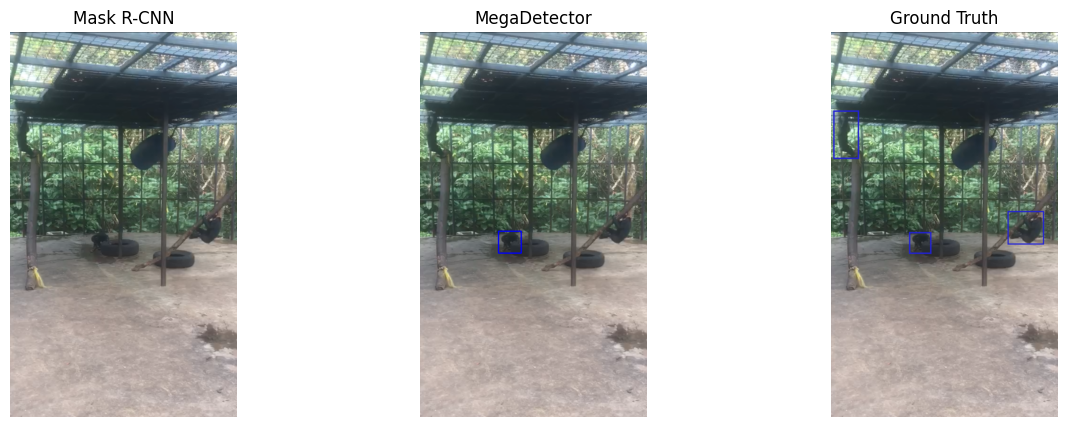

W0000 00:00:1730891759.018428   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

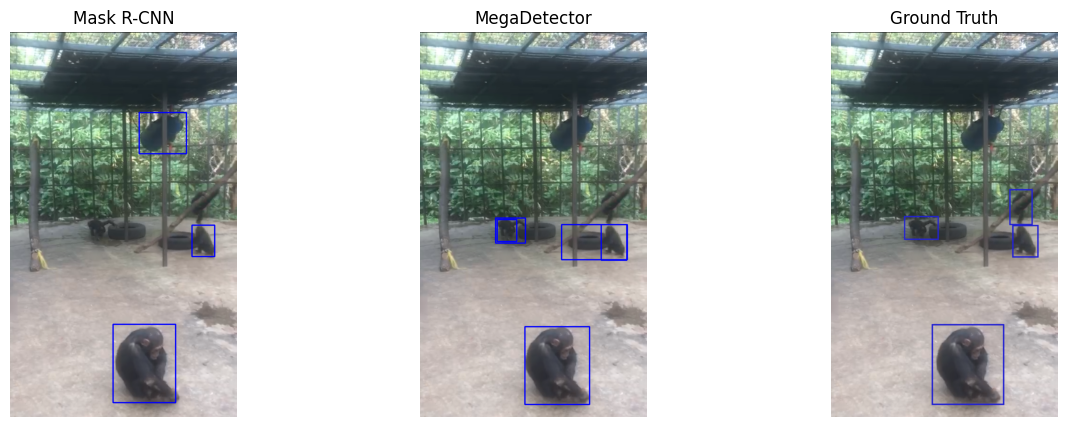

W0000 00:00:1730891771.992826   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

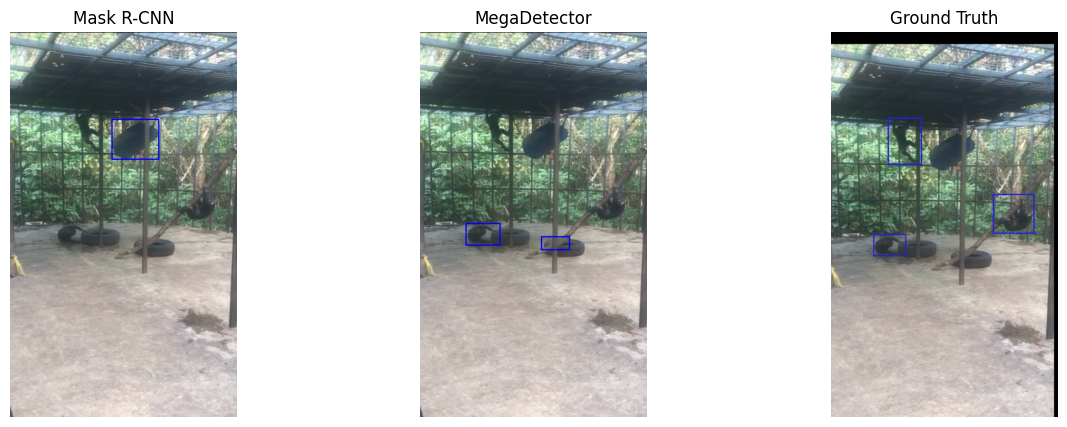

W0000 00:00:1730891784.321148   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

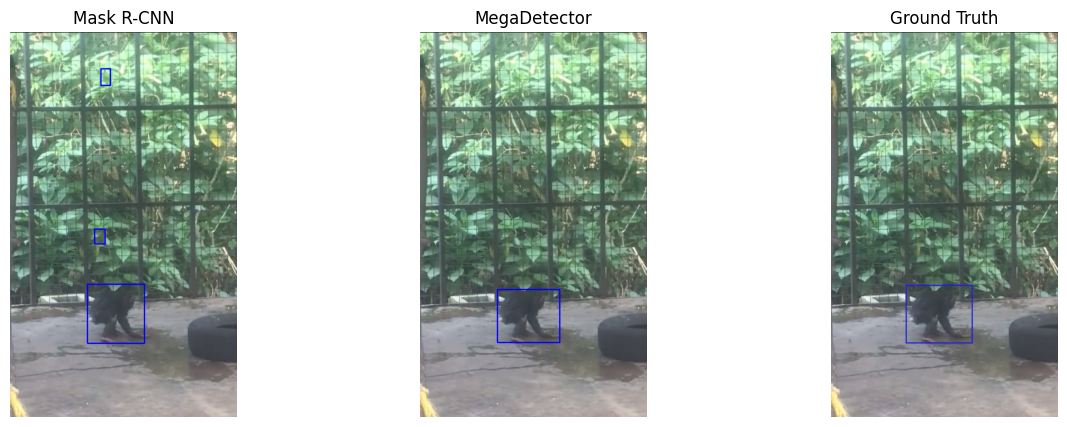

W0000 00:00:1730891796.663263   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

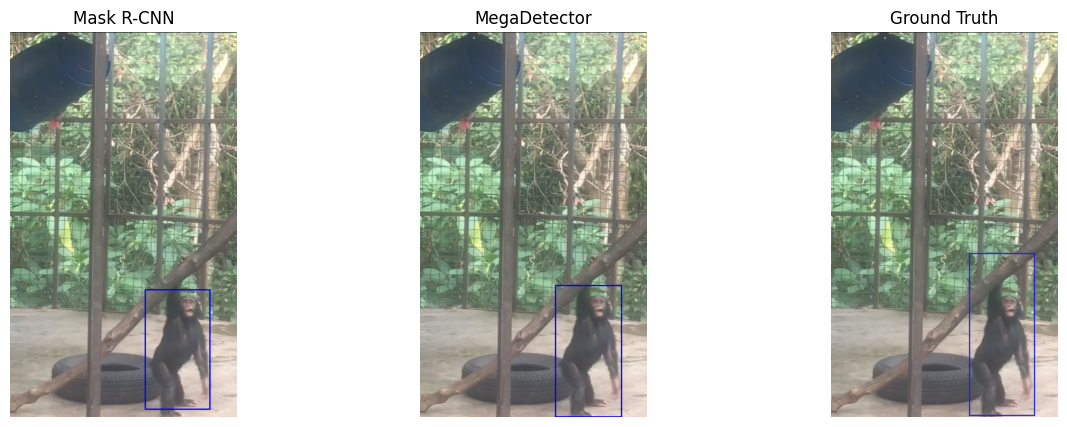

W0000 00:00:1730891808.309453   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

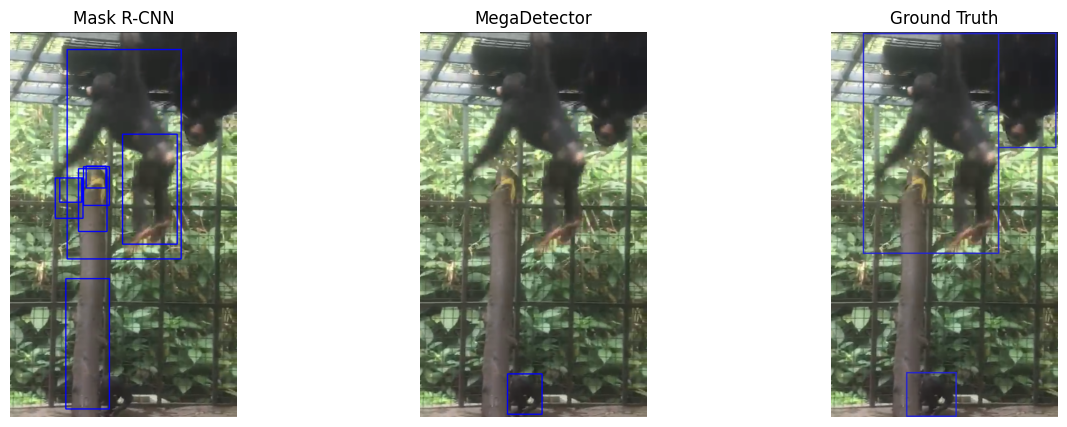

W0000 00:00:1730891819.670429   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

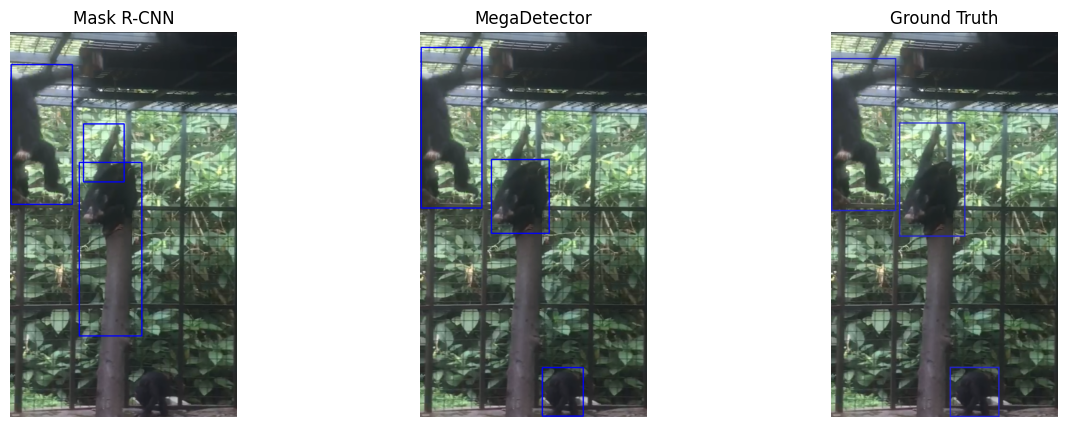

W0000 00:00:1730891831.665677   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

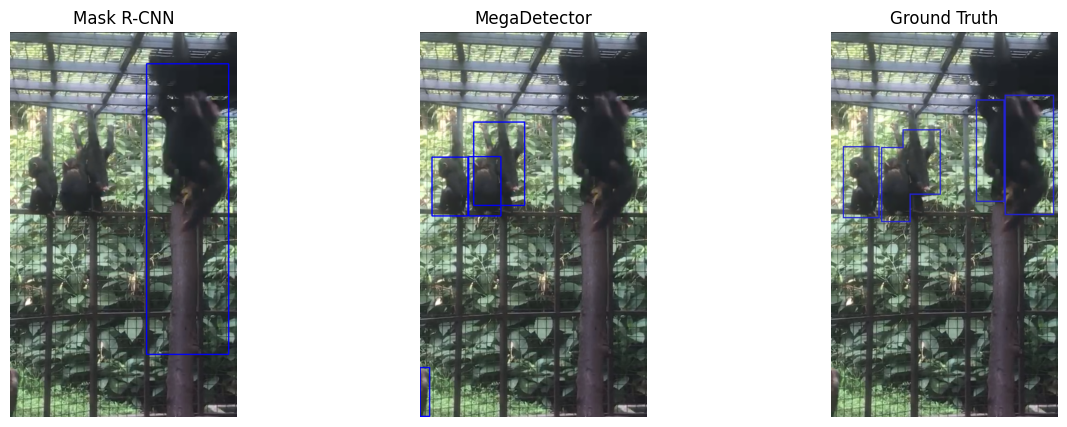

W0000 00:00:1730891843.321063   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

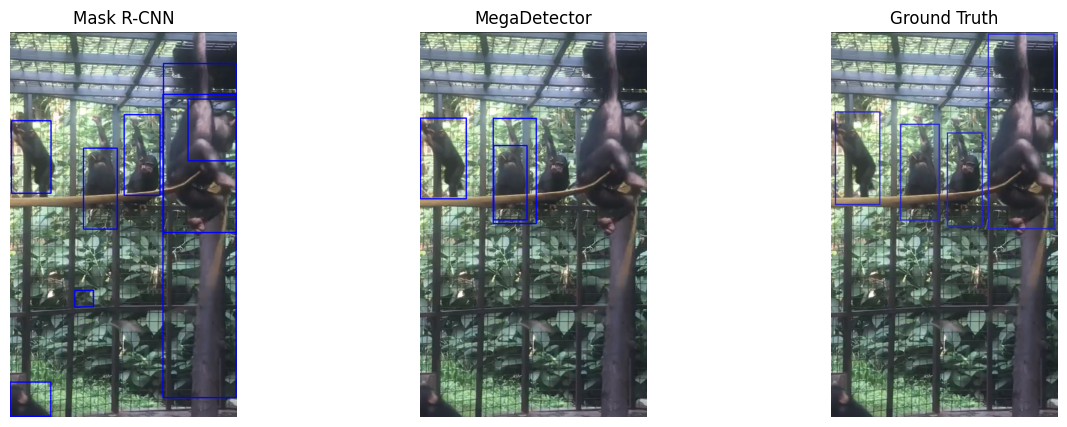

W0000 00:00:1730891855.540641   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

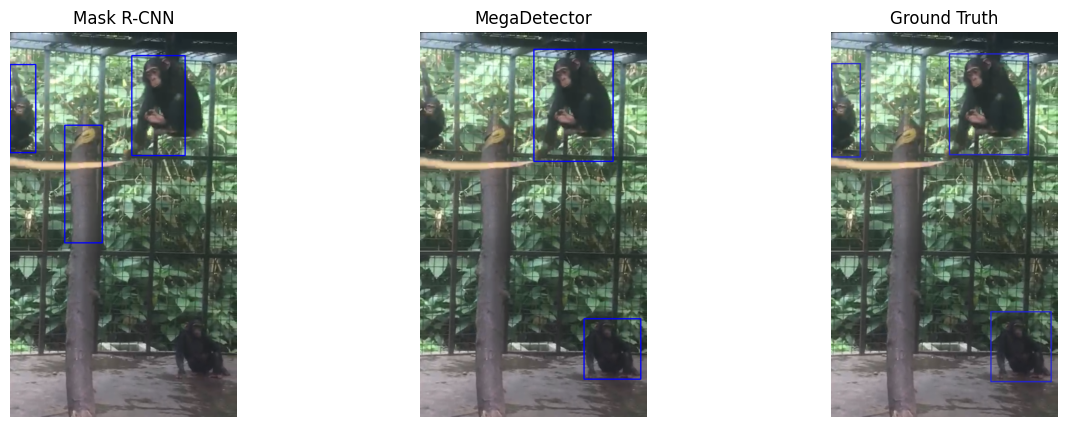

W0000 00:00:1730891867.310218   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

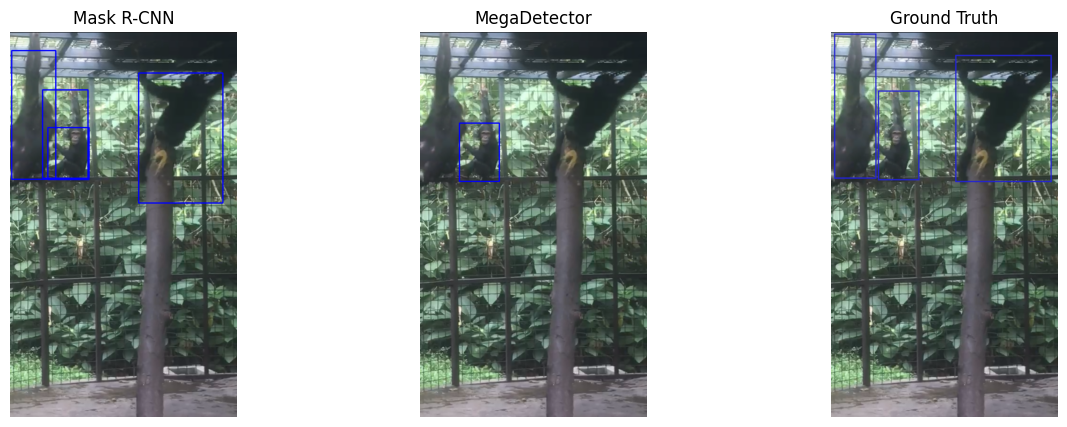

W0000 00:00:1730891878.844944   98031 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -1047 } dim { size: -1048 } dim { size: -1049 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -108 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -108 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "109" frequency: 2496 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 25165824 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: 

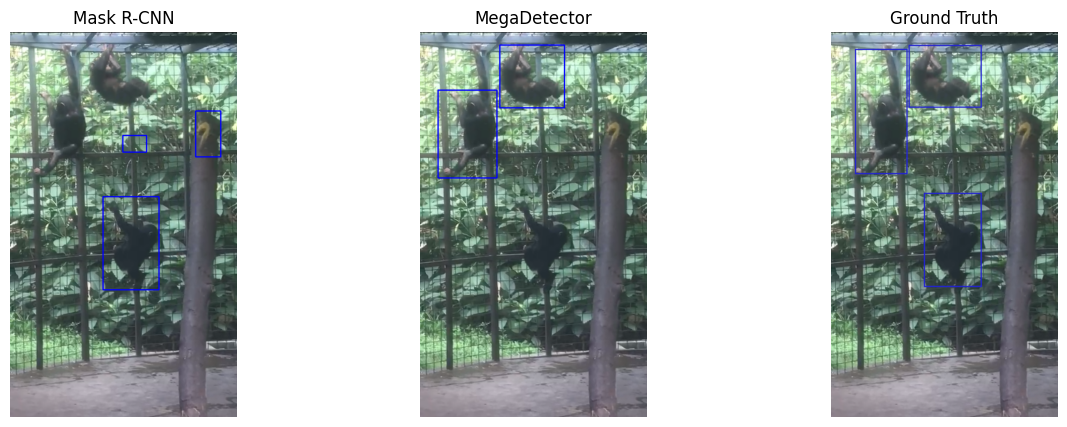

In [32]:
for i in range(1, 13):
    path_blank = f"{input_image_path}/blank/{i}.png"
    path_ground_truth = f"{input_image_path}/ground truth/{i}.png"
    img_pred_maskrcnn = process_image(path_blank, "maskrcnn")
    img_pred_MD = process_image(path_blank, "megadetector")
    img_ground_truth = cv2.imread(path_ground_truth)
    show_images(
        [img_pred_maskrcnn, img_pred_MD, img_ground_truth],
        ["Mask R-CNN", "MegaDetector", "Ground Truth"])